### 0) Import Libraries

In [1]:
# Import libraries
from matplotlib import pyplot as plt

import os

from PIL import Image
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim

## 1) Create dataset.

### 1.1) Get folder paths that contains the images.

In [2]:
# 1.1) Get folder paths that contains the images.

image_folder_list = []
input_path = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/'


files = os.listdir(input_path)

for file in files:
    file_path = input_path + file
    if os.path.isdir(file_path):
        file_path = file_path + "/" + file
        print(file_path)
        print(len(os.listdir(file_path)))
        image_folder_list.append(file_path)
        

/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel
1000
/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat
1000
/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass
1000
/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Red Mullet/Red Mullet
1000
/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Trout/Trout
1000
/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Striped Red Mullet/Striped Red Mullet
1000
/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp
1000
/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Gilt-Head Bream/Gilt-Head Bream
1000
/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Red Sea Bream/Red Sea Bream
1000


### 1.2) Create custom dataset class which takes folder paths and the way to transform images.

In [3]:
# 1.2) Create custom dataset class which takes folder paths and the way to transform images.

class CustomImageDataset(Dataset):
    def __init__(self, folder_paths, transform=None):
        self.file_paths = []
        self.labels = []
        self.transform = transform

        # Populate file_paths and labels
        for folder_path in folder_paths:
            class_name = os.path.basename(folder_path)
            for root, _, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(('.png', '.jpg', '.jpeg')):
                        self.file_paths.append(os.path.join(root, file))
                        self.labels.append(class_name)

        self.classes = sorted(set(self.labels))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.labels = [self.class_to_idx[label] for label in self.labels]

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        return image, label

### 1.3) Create dataset object from the class we defined earlier. Split it into train and test.

In [4]:
# 1.3) Create dataset object from the class we defined earlier. Split it into train and test.

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = CustomImageDataset(image_folder_list, transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 2) Train an ANN Model.

### 2.1) Define model in a custom class.

In [5]:
# 2.1) Define model in a custom class.

class FishImageANN(nn.Module):
    def __init__(self):
        super(FishImageANN, self).__init__()
        self.fc1 = nn.Linear(224*224*3, 1024)
        self.fc2 = nn.Linear(1024, 512)  
        self.fc3 = nn.Linear(512, 128)  
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 9)
        
        self.dropout = nn.Dropout(0.5)  # Dropout layer for regularization
        self.batch_norm1 = nn.BatchNorm1d(1024)  # Batch normalization after first layer
        self.batch_norm2 = nn.BatchNorm1d(512)  # Batch normalization after second layer
        self.batch_norm3 = nn.BatchNorm1d(128)  # Batch normalization after third layer

    def forward(self, x):
        x = x.view(-1, 3 * 224 * 224)  # Flatten the input image tensor
        x = F.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.batch_norm2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.batch_norm3(self.fc3(x)))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

### 2.2) Train the model.

In [6]:
# 2.2) Train the model.

model = FishImageANN()

# Enable GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs to train
num_epochs = 10

# Loss and accuracy arrays
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

# Training and evaluation loop
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    # Train phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track training loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate training loss and accuracy
    train_loss = running_loss / total
    train_acc = correct / total
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # Test phase
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():  # Disable gradient calculation during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track validation loss and accuracy
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

    # Calculate validation loss and accuracy
    test_loss = test_loss / test_total
    test_acc = test_correct / test_total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

Epoch 1/10
----------
Train Loss: 1.5122, Train Accuracy: 0.4608
Test Loss: 1.0365, Test Accuracy: 0.6422
Epoch 2/10
----------
Train Loss: 0.8814, Train Accuracy: 0.6919
Test Loss: 0.7186, Test Accuracy: 0.7528
Epoch 3/10
----------
Train Loss: 0.6379, Train Accuracy: 0.7829
Test Loss: 0.3956, Test Accuracy: 0.8722
Epoch 4/10
----------
Train Loss: 0.4950, Train Accuracy: 0.8335
Test Loss: 0.3227, Test Accuracy: 0.8889
Epoch 5/10
----------
Train Loss: 0.4054, Train Accuracy: 0.8596
Test Loss: 0.3065, Test Accuracy: 0.8900
Epoch 6/10
----------
Train Loss: 0.3380, Train Accuracy: 0.8814
Test Loss: 0.2202, Test Accuracy: 0.9194
Epoch 7/10
----------
Train Loss: 0.2907, Train Accuracy: 0.8978
Test Loss: 0.2007, Test Accuracy: 0.9361
Epoch 8/10
----------
Train Loss: 0.2431, Train Accuracy: 0.9179
Test Loss: 0.2084, Test Accuracy: 0.9233
Epoch 9/10
----------
Train Loss: 0.2356, Train Accuracy: 0.9192
Test Loss: 0.1590, Test Accuracy: 0.9411
Epoch 10/10
----------
Train Loss: 0.2208, Tra

### 2.3) Visualize train and test losses.

<function matplotlib.pyplot.show(close=None, block=None)>

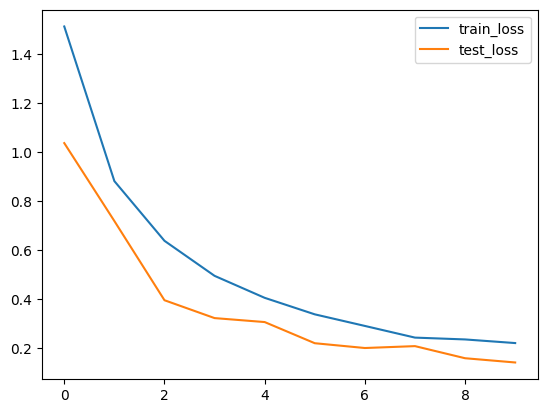

In [7]:
# 2.3) Visualize train and test losses.

plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list,label='test_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

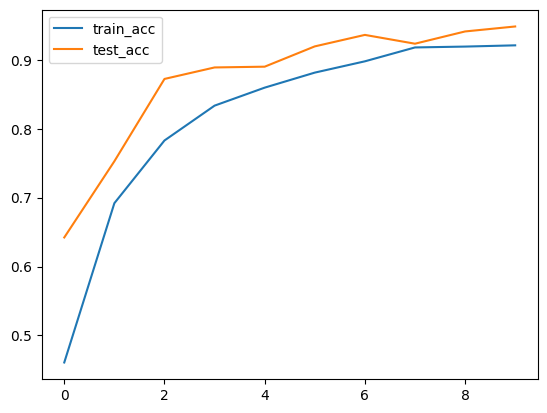

In [8]:
plt.plot(train_acc_list, label='train_acc')
plt.plot(test_acc_list,label='test_acc')
plt.legend()
plt.show

#### Did overfitting occured?

Since train accuracy and test accuracy is correlated, we can say that our model did not overfitted.

### 2.4) Save the model.

In [9]:
# 2.4) Save the model.

torch.save(model, '/kaggle/working/model.pth')